# Forecasting - fit to a known distribution

Fitting data to known distributions use is done using [Chi2Fit](https://hex.pm/packages/chi2fit).

## Table of contents

* [Set-up](#Set-up)
* [Data and simulation set-up](#Data-and-simulation-set-up)
* [Preparation](#preparation)
* [Forecasting using a Poisson distribution](#Forecasting-using-a-Poisson-distribution)
* [Monte Carlo](#Monte-Carlo)
* [Rate error propagation: Total Monte CarloTotal Monte Carlo](#Rate-error-propagation:-Total-Monte-Carlo)
* [References](#References)

## Set-up

In [1]:
alias Chi2fit.Distribution, as: D
alias Chi2fit.Fit, as: F
alias Chi2fit.Matrix, as: M
alias Chi2fit.Utilities, as: U
alias Gnuplotlib, as: P
alias Exboost.Math

Exboost.Math

## Data and simulation set-up

As an example consider the throughput of completed backlog items. At the end of a fixed time period we count the number of backlog items that a teram completes. Partially completed items are excluded from the count.

In [2]:
data = [3,3,4,4,7,5,1,11,5,6,3,6,6,5,4,10,4,5,8,2,4,12,5]

[3, 3, 4, 4, 7, 5, 1, 11, 5, 6, 3, 6, 6, 5, 4, 10, 4, 5, 8, 2, 4, 12, 5]

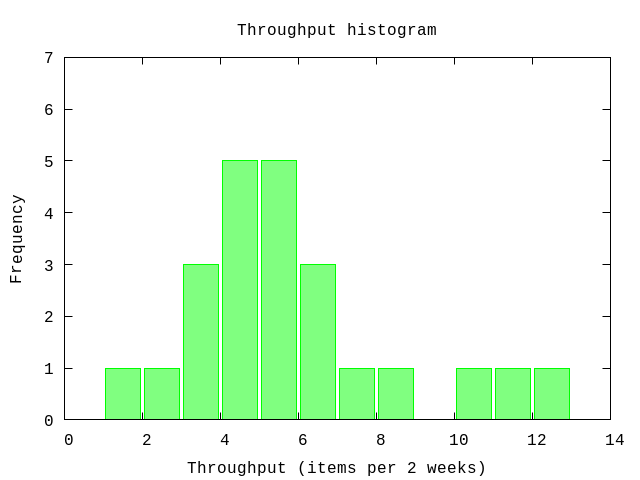

In [3]:
P.histogram(data,
    plottitle: "Throughput histogram",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Frequency",
    yrange: '[0:7]')
:"this is an inline image"

Other parameters that affect the forecasting are listed below. Please adjust to your needs.

In [4]:
# The size of the backlog, e.g. 100 backlog items
size = 100

# Number of iterations to use in the Monte Carlo
iterations = 1000

# The size of bins for grouping the data
binsize = 1

# Number of probes to use in the chi2 fit
probes = 10_000

# The range of the parameter to look for a (global) minimum
initial = {1,10}

{1, 10}

## Preparation

Next, we convert the throughput data to a histogram. To this end we group the data in bins of size 1 starting at 0.

In [5]:
hdata = U.to_bins data, {binsize,0}

[{1, 0.043478260869565216, 0.0058447102657877, 0.13689038224309594}, {2, 0.08695652173913043, 0.02977628442357071, 0.1905937209791003}, {3, 0.21739130434782608, 0.1263699563343216, 0.33774551477037923}, {4, 0.43478260869565216, 0.3160946312914347, 0.5600249434832333}, {5, 0.6521739130434783, 0.5263221461493021, 0.7626298741894857}, {6, 0.782608695652174, 0.6622544852296207, 0.8736300436656784}, {7, 0.8260869565217391, 0.709703289667655, 0.9080712005244068}, {8, 0.8695652173913043, 0.7585954661422599, 0.9405937209791002}, {10, 0.9130434782608695, 0.8094062790208998, 0.9702237155764294}, {11, 0.9565217391304348, 0.8631096177569041, 0.9941552897342123}, {12, 1.0, 0.9225113769324543, 1.0}]

The data returned contains a list of tuples each describing a bin:
* the end-point of the bin,
* the proportional number of events for this bin (the total count is normalized to one),
* the lower value of the error bound,
* the upper value of the error bound.

As can be seen the sizes of the lower and upper bounds are different in value, i.e. they are asymmetrical. The contribution or weight to the likelihood function used in fitting known distributions will de different depending on whether the observed value if larger or smaller than the predicted value. This is specified by using the option `:linear` (see below). See [3] for details.

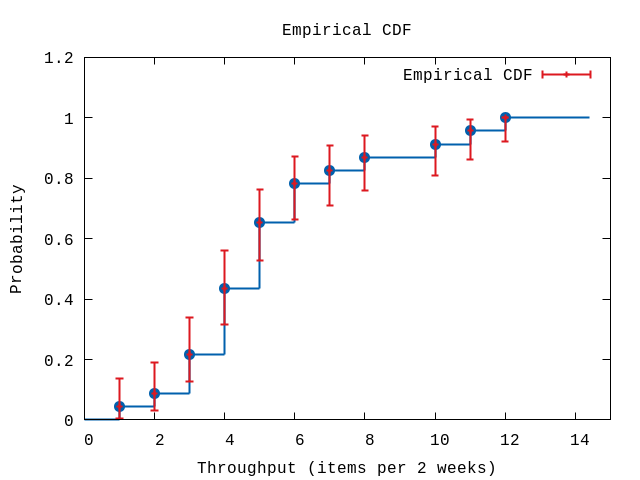

In [6]:
P.ecdf(hdata,
    plottitle: "Empirical CDF",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:15]')
:"this is an inline image"

## Forecasting using a Poisson distribution

Instead of directly using the raw data captured one can also use a known probability distribution. The parameter of the distribution is matched to the data. After matching the parameter value one uses the known distribution to forecast.

Here, we will use the __Poisson distribution__ [1]. This basically assumes that the data points are independent of each other.

The code below uses basic settings of the commands provided by `Chi2Fit`. More advanced options can be found at [2]. First a fixed number of random parameter values are tried to get a rough estimate. The option `probes` equals the number of tries. Furthermore, since we are fitting a probability distribution which has values on the interval `[0,1]` the errors are asymmetrical. This is specified by the option `linear`. 

In [7]:
model = D.model "poisson"
options = [probes: probes, smoothing: false, model: :linear, saved?: true]
result = {_,parameters,_,saved} = F.chi2probe hdata, [initial], {Distribution.cdf(model), &F.nopenalties/2}, options
U.display result

Initial guess:
    chi2:		3.7680909998944285
    pars:		[5.467701988785316]
    ranges:		{[5.26279288835782, 5.687565561629632]}



:ok

The errors reported is the found range of parameter values where the corresponding `chi2` values are within 1 of the found minimum value.

After roughly locating the minimum we do a more precise (and computationally more expensive) search for the minimum.

In [8]:
options = [{:probes,saved}|options]
result = {_,cov,parameters,_} = F.chi2fit hdata, {parameters, Distribution.cdf(model), &F.nopenalties/2}, 10, options
U.display(hdata,model,result,options)

Final:
    chi2:		3.7680887442307553
    Degrees of freedom:	10
    gradient:		[-4.284788519377549e-9]
    parameters:		[5.4680263772768605]
    errors:		[0.21599806132547897]
    ranges:
			chi2:		3.7680887442307553	-	4.752487946555217
			parameter:	5.26279288835782	-	5.687565561629632


:ok

For a (local) minimum the value of the gradient should be very close to zero.

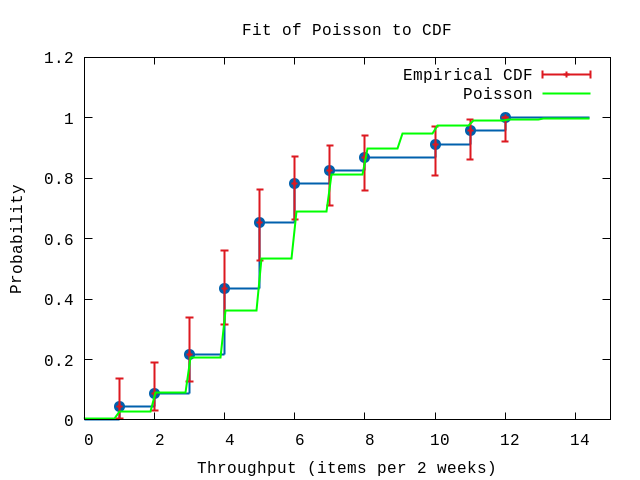

In [9]:
P.ecdf(hdata,
    plottitle: "Fit of Poisson to CDF",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Probability",
    xrange: '[0:15]',
    title: "Poisson",
    func: & Distribution.cdf(model).(&1,parameters))
:"this is an inline image"

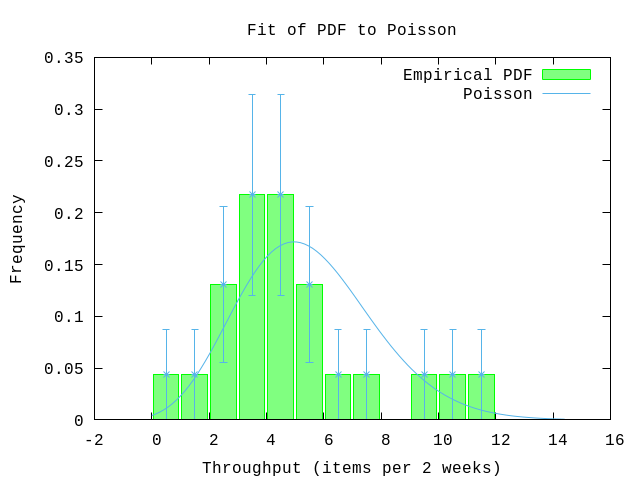

In [10]:
rate = hd(parameters)
pdf = fn x -> :math.pow(rate,x)*:math.exp(-rate)/Math.tgamma(x+1) end
P.pdf(data,
    plottitle: "Fit of PDF to Poisson",
    xlabel: "Throughput (items per 2 weeks)",
    ylabel: "Frequency",
    yrange: '[0:0.35]',
    pdf: pdf,
    title: "Poisson")
:"this is an inline image"

Again, using a Monte Carlo simulation we estimate the number of iterations and the range to expect.

In [16]:
{avg,sd,all} = U.mc(iterations, U.forecast_duration(fn -> Distribution.random(model).(parameters) end, size), collect_all?: true)
U.display {avg,sd,:+}

50%    => 19.0 units
84%    => 21.0 units
97.5%  => 23.0 units
99.85% => 25.0 units


:ok

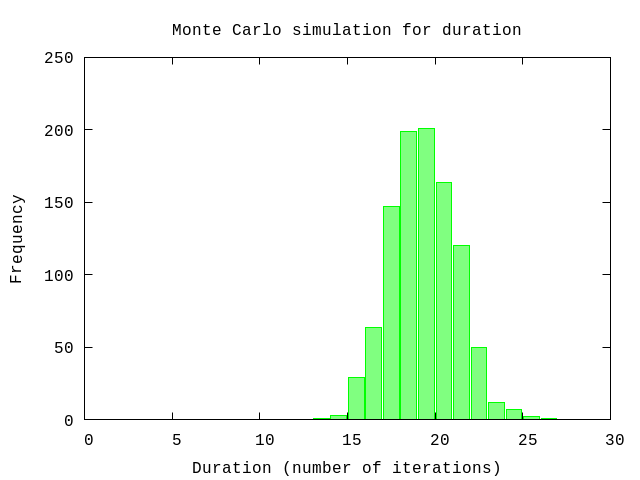

In [17]:
P.histogram(all,
    plottitle: "Monte Carlo simulation for duration",
    xlabel: "Duration (number of iterations)",
    ylabel: "Frequency",
    xrange: '[0:30]')
:"this is an inline image"

## Rate error propagation: Total Monte Carlo

In the results of a Monte Carlo simulation the errors reported and the range of the number of iterations is the statistical error associated with the Monte Carlo simulation. It dopes not take into account the uncertainty of the parameter used in the fitted probability distribution function.

In Total Monte Carlo [4] multiple Monte Carlo simulations are done that correspond to the extreme values of the error bounds of the used parameters. The error results is of a different nature than the statistical error from the Monte Carlo simulation. These error reported separately.

In [18]:
# Pick up the error in the paramater value
param_errors = cov |> M.diagonal |> Enum.map(fn x->x|>abs|>:math.sqrt end)
[sd_rate] = param_errors

{avg_min,_} = U.mc(iterations, fn -> U.forecast(fn -> Distribution.random(model).([rate-sd_rate]) end, size) end)
{avg_max,_} = U.mc(iterations, fn -> U.forecast(fn -> Distribution.random(model).([rate+sd_rate]) end, size) end)

sd_min = avg - avg_max
sd_plus = avg_min - avg

IO.puts "Number of iterations to complete the backlog:"
IO.puts "#{Float.round(avg,1)} (+/- #{Float.round(sd,1)}) (-#{Float.round(sd_plus,1)} +#{Float.round(sd_min,1)})"

Number of iterations to complete the backlog:
18.8 (+/- 1.9) (-0.7 +0.8)


:ok

The first error is symmetric while the second error reported is asymmetric.

#### Combining the errors

We now have estimated two erros which have a different origin:

1. _statistical error_ caused by the nature of the Poisson distribution as determined in [Forecasting using a Poisson distribution](#Forecasting-using-a-Poisson-distribution), and
1. _systematic error_ caused by the error in the deliveray rate in [this section](#Rate-error-propagation:-Total-Monte-Carlo)

Making the assumption that both are Gaussian - which is true for the _systematic error_ but which is false for the _systematic error_ - allows us to combine the two by quadratically addition.

In [21]:
sd_avg = (sd_plus + sd_min)/2
total = :math.sqrt sd*sd + sd_avg*sd_avg
U.display {avg,total,:+}

50%    => 19.0 units
84%    => 21.0 units
97.5%  => 23.0 units
99.85% => 25.0 units


:ok

## References

[1] _Poisson distribution_, https://en.wikipedia.org/wiki/Poisson_distribution/<br>
[2] _Chi2Fit_, Pieter Rijken, 2018, https://hex.pm/packages/chi2fit<br>
[3] _Asymmetric errors_, Roger Barlow, Manchester University, UK and Stanford University, USA, PHYSTAT2003, SLAC, Stanford, California, September 8-11, 2003, https://www.slac.stanford.edu/econf/C030908/papers/WEMT002.pdf<br>
[4] _Efficient use of Monte Carlo: uncertainty propagation_, D. Rochman et. al., Nuclear Science and Engineering, 2013, ftp://ftp.nrg.eu/pub/www/talys/bib_rochman/fastTMC.pdf